In [ ]:
!pip install -q transformers datasets torch scikit-learn matplotlib seaborn

In [ ]:
!pip install -q accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 9.0 MB/s eta 0:00:00


In [ ]:
import json
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc
)

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

from google.colab import drive


In [ ]:
data = []
paths = ["train.jsonl", "val.jsonl"]

for path in paths:
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                obj = json.loads(line)
                data.append({"text": obj["text"], "label": obj["label"]})
            except:
                pass

df = pd.DataFrame(data)

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

In [ ]:
def build_dataset(df, tokenizer, max_len=256):
    enc = tokenizer(
        df["text"].tolist(),
        truncation=True,
        padding="max_length",
        max_length=max_len
    )
    return Dataset.from_dict({
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "labels": df["label"].tolist()
    })

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

In [ ]:
models_to_test = [
    "google/electra-small-discriminator",
    "microsoft/MiniLM-L12-H384-uncased",
    "prajjwal1/bert-mini"
]

results = []

for model_name in models_to_test:
    print(f"\n===== TRAINING {model_name} =====")

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_dataset = build_dataset(train_df, tokenizer)
    test_dataset  = build_dataset(test_df, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    args = TrainingArguments(
        output_dir=f"./results_{model_name.replace('/', '_')}",
        num_train_epochs=1,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        eval_strategy="epoch",
        save_strategy="no",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_res = trainer.evaluate()
    eval_res["model"] = model_name
    results.append(eval_res)


===== TRAINING google/electra-small-discriminator =====


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.rename(columns={
    "eval_accuracy": "accuracy",
    "eval_precision": "precision",
    "eval_recall": "recall",
    "eval_f1": "f1"
})
results_df = results_df[["model", "accuracy", "precision", "recall", "f1"]]
results_df = results_df.sort_values("f1", ascending=False)

In [ ]:
best_model_name = results_df.iloc[0]["model"]
print("BEST MODEL:", best_model_name)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(best_model_name)
train_dataset = build_dataset(train_df, tokenizer, max_len=512)
test_dataset  = build_dataset(test_df, tokenizer, max_len=512)

model = AutoModelForSequenceClassification.from_pretrained(
    best_model_name,
    num_labels=2
)

training_args = TrainingArguments(
    output_dir="./final_model",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

import time
start_time = time.time()

trainer.train()

end_time = time.time()
total_training_time = end_time - start_time

print(f"\nTotal training time for best model: {total_training_time:.2f} seconds")

trainer.save_model("./final_model")
tokenizer.save_pretrained("./final_model")

In [ ]:
loaded_tokenizer = AutoTokenizer.from_pretrained("./final_model")
loaded_model = AutoModelForSequenceClassification.from_pretrained("./final_model")

test_dataset_loaded = build_dataset(test_df, loaded_tokenizer, max_len=512)

eval_args = TrainingArguments(
    output_dir="./eval_tmp",
    per_device_eval_batch_size=32,
    report_to="none"
)

eval_trainer = Trainer(
    model=loaded_model,
    args=eval_args,
    eval_dataset=test_dataset_loaded,
    compute_metrics=compute_metrics
)

final_eval = eval_trainer.evaluate()
final_eval

{'eval_loss': 0.032290980219841,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.9921245421245422,
 'eval_precision': 0.9923371647509579,
 'eval_recall': 0.9949763593380615,
 'eval_f1': 0.9936550095912646,
 'eval_runtime': 57.6711,
 'eval_samples_per_second': 94.675,
 'eval_steps_per_second': 2.965}

In [ ]:
final_model_df = pd.DataFrame([{
    "model_name": best_model_name + " (fine-tuned)",
    "accuracy": final_eval["eval_accuracy"],
    "precision": final_eval["eval_precision"],
    "recall": final_eval["eval_recall"],
    "f1": final_eval["eval_f1"],
    "type": "fine-tuned"
}])

In [ ]:
final_model_df

,model_name,accuracy,precision,recall,f1,type
0,microsoft/MiniLM-L12-H384-uncased (fine-tuned),0.992125,0.992337,0.994976,0.993655,fine-tuned


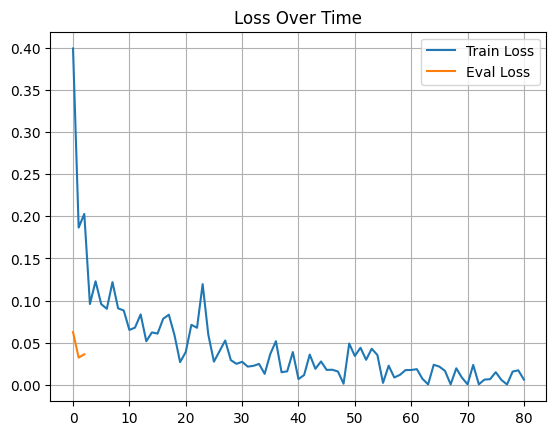

In [ ]:
logs = trainer.state.log_history

train_losses = [x["loss"] for x in logs if "loss" in x]
eval_losses  = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.plot(train_losses, label="Train Loss")
plt.plot(eval_losses, label="Eval Loss")
plt.title("Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pred_output = trainer.predict(test_dataset)
preds = pred_output.predictions.argmax(-1)
labels = np.array(test_df["label"])

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Human", "AI"],
            yticklabels=["Human", "AI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Final Model")
plt.show()

In [ ]:
probs = pred_output.predictions[:,1]
labels = np.array(test_df['label'])

fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Final Model")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
plt.figure(figsize=(7,4))
plt.hist(probs[labels==0], bins=30, alpha=0.6, label="Human")
plt.hist(probs[labels==1], bins=30, alpha=0.6, label="AI")
plt.title("Prediction Probability Distribution")
plt.xlabel("Probability of being AI-generated")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
zero_shot_models = [
    "Hello-SimpleAI/chatgpt-detector-roberta",
    "roberta-base-openai-detector",
    "nothingiisreal/open-gpt-3.5-detector"
]

zero_results = []

for model_name in zero_shot_models:
    print(f"\n===== ZERO-SHOT: {model_name} =====")

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)

        test_dataset = build_dataset(test_df, tokenizer, max_len=512)

        args = TrainingArguments(output_dir="./tmp", report_to="none")

        trainer = Trainer(
            model=model,
            args=args,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics
        )

        res = trainer.evaluate()
        res["model"] = model_name
        zero_results.append(res)

    except Exception as e:
        print("ERROR:", e)


===== ZERO-SHOT: Hello-SimpleAI/chatgpt-detector-roberta =====


tokenizer_config.json:   0%|          | 0.00/391 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/858 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]


===== ZERO-SHOT: roberta-base-openai-detector =====


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



===== ZERO-SHOT: nothingiisreal/open-gpt-3.5-detector =====


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
zero_shot_df = pd.DataFrame(zero_results)

zero_shot_df = zero_shot_df.rename(columns={
    "eval_accuracy": "accuracy",
    "eval_precision": "precision",
    "eval_recall": "recall",
    "eval_f1": "f1"
})

zero_shot_df = zero_shot_df[["model", "accuracy", "precision", "recall", "f1"]]

zero_shot_df = zero_shot_df.sort_values("f1", ascending=False)

zero_shot_df

,model,accuracy,precision,recall,f1
2,nothingiisreal/open-gpt-3.5-detector,0.869963,0.987245,0.800532,0.884138
1,roberta-base-openai-detector,0.573626,0.603044,0.913121,0.726375
0,Hello-SimpleAI/chatgpt-detector-roberta,0.491209,0.948225,0.189421,0.315764


In [ ]:
zero_shot_df["type"] = "zero-shot"
zero_shot_df = zero_shot_df.rename(columns={"model": "model_name"})
zero_shot_df = zero_shot_df[["model_name", "accuracy", "precision", "recall", "f1", "type"]]

In [ ]:
combined_df = pd.concat([final_model_df, zero_shot_df], ignore_index=True)
combined_df

,model_name,accuracy,precision,recall,f1,type
0,microsoft/MiniLM-L12-H384-uncased (fine-tuned),0.992125,0.992337,0.994976,0.993655,fine-tuned
1,nothingiisreal/open-gpt-3.5-detector,0.869963,0.987245,0.800532,0.884138,zero-shot
2,roberta-base-openai-detector,0.573626,0.603044,0.913121,0.726375,zero-shot
3,Hello-SimpleAI/chatgpt-detector-roberta,0.491209,0.948225,0.189421,0.315764,zero-shot


In [ ]:
!cp -r final_model /content/drive/MyDrive/